# Production, Trade and Supply of Energy - Predictive Modeling Analysis
## Assignment II: Hypothesis Testing and Machine Learning

This notebook implements supervised learning models to test hypotheses about energy production, trade patterns, and consumption across regions and years.

In [116]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from src.data_processor import DataProcessor
from src.feature_engineer import FeatureEngineer
from src.model_trainer import ModelTrainer
from src.model_evaluator import ModelEvaluator

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All modules imported successfully")

✓ All modules imported successfully


# Part 1: Hypothesis Formulation and Data Preparation

## Research Questions and Hypotheses
This analysis tests three key hypotheses about global energy systems:

**Hypothesis 1: Energy Balance Prediction (Regression)**
- **Question:** Can primary energy production, net imports, and stock changes accurately predict total energy supply?
- **H₀ (Null):** These variables are not significantly predictive of total supply (R² < 0.5)
- **H₁ (Alternative):** These variables significantly predict total supply (R² ≥ 0.8)
- **Rationale:** Understanding energy balances is critical for predicting national energy availability
- **Evidence:** Test set R² score, RMSE, and cross-validation performance

**Hypothesis 2: Importer Classification (Classification)**
- **Question:** Can we classify countries as importers vs exporters based on energy characteristics?
- **H₀ (Null):** Classification accuracy < 0.75
- **H₁ (Alternative):** Classification accuracy ≥ 0.85
- **Rationale:** Identifying importer/exporter status helps understand global trade dependencies
- **Evidence:** Classification accuracy, precision, recall, F1 score

**Hypothesis 3: Per Capita Consumption Prediction (Regression)**
- **Question:** Does total supply combined with production/import patterns predict per-capita energy consumption?
- **H₀ (Null):** Model R² < 0.6
- **H₁ (Alternative):** Model R² ≥ 0.75
- **Rationale:** Per-capita consumption indicates development level and reveals consumption disparities
- **Evidence:** Test R² score and model comparison across multiple algorithms

In [117]:
## Section 1: Data Loading and Cleaning

dp = DataProcessor("../dataset/Production,Trade and Supply of Energy.csv")

raw = dp.load_data()
print("✓ Raw Data Loaded")
print(f"  Shape: {raw.shape}")
display(raw.head())

clean = dp.clean()
print("\n✓ Data Cleaned and Pivoted to Wide Format")
print(f"  Shape: {clean.shape}")
print(f"  Columns: {clean.shape[1]}")
display(clean.head())

# Summary statistics
print("\n Data Quality Summary:")
print(f"  Total records: {clean.shape[0]}")
print(f"  Total features: {clean.shape[1]}")
print(f"  Missing values: {clean.isnull().sum().sum()}")
print(f"  Date range: {clean['Year'].min():.0f} - {clean['Year'].max():.0f}")
print(f"  Unique regions: {clean['Region'].nunique()}")

INFO:src.data_processor:Loaded 8584 rows from ../dataset/Production,Trade and Supply of Energy.csv
INFO:src.data_processor:Data loaded successfully with 8583 records
INFO:src.data_processor:Data loaded successfully with 8583 records


✓ Raw Data Loaded
  Shape: (8583, 5)


RegionCode                         Region  Year  \
1          1  Total, all countries or areas  1995   
2          1  Total, all countries or areas  2000   
3          1  Total, all countries or areas  2005   
4          1  Total, all countries or areas  2010   
5          1  Total, all countries or areas  2015   

                                   Series    Value  
1  Primary energy production (petajoules)  381,716  
2  Primary energy production (petajoules)  412,282  
3  Primary energy production (petajoules)  477,690  
4  Primary energy production (petajoules)  530,871  
5  Primary energy production (petajoules)  569,646

INFO:src.data_processor:Removed 0 rows with missing values
INFO:src.data_processor:Pivoted data to wide format: 1856 rows, 7 columns
INFO:src.data_processor:Pivoted data to wide format: 1856 rows, 7 columns



✓ Data Cleaned and Pivoted to Wide Format
  Shape: (1856, 7)
  Columns: 7


Region  Year  Changes in stocks (petajoules)  \
0  Afghanistan  1995                             0.0   
1  Afghanistan  2000                             0.0   
2  Afghanistan  2005                            -2.0   
3  Afghanistan  2010                             0.0   
4  Afghanistan  2015                             4.0   

   Net imports [Imports - Exports - Bunkers] (petajoules)  \
0                                               17.0        
1                                               14.0        
2                                               22.0        
3                                               99.0        
4                                              111.0        

   Primary energy production (petajoules)  Supply per capita (gigajoules)  \
0                                    16.0                             2.0   
1                                    18.0                             2.0   
2                                    23.0                             2.0   
3                                    41.0                             5.0   
4                                    61.0                             5.0   

   Total supply (petajoules)  
0                       33.0  
1                       31.0  
2                       46.0  
3                      141.0  
4                      167.0


 Data Quality Summary:
  Total records: 1856
  Total features: 7
  Missing values: 697
  Date range: 1995 - 2021
  Unique regions: 240


## Section 2: Feature Engineering

fe = FeatureEngineer(clean)
df_fe = fe.create_features()

print("✓ Features Engineered Successfully")
feature_report = fe.get_feature_report()
print(f"\n📋 Feature Engineering Log:")
for feature, description in feature_report.items():
    print(f"  • {feature}: {description}")

print(f"\n✓ Dataset shape after engineering: {df_fe.shape}")
print(f"  New columns: {list(feature_report.keys())}")
display(df_fe.head())

In [118]:
fe = FeatureEngineer(clean)
df_fe = fe.create_features()

print(df_fe.columns.tolist())
df_fe.head()


INFO:src.feature_engineer:Detected columns: {'prod': 'Primary energy production (petajoules)', 'netimp': 'Net imports [Imports - Exports - Bunkers] (petajoules)', 'stock': 'Changes in stocks (petajoules)', 'supply': 'Total supply (petajoules)', 'percap': 'Supply per capita (gigajoules)'}
INFO:src.feature_engineer:Created is_importer feature: {1: 1355, 0: 501}
INFO:src.feature_engineer:Created log feature: Primary energy production (petajoules)_log
INFO:src.feature_engineer:Created log feature: Net imports [Imports - Exports - Bunkers] (petajoules)_log
INFO:src.feature_engineer:Created log feature: Total supply (petajoules)_log
INFO:src.feature_engineer:Feature engineering complete. Created 4 new features
INFO:src.feature_engineer:Created is_importer feature: {1: 1355, 0: 501}
INFO:src.feature_engineer:Created log feature: Primary energy production (petajoules)_log
INFO:src.feature_engineer:Created log feature: Net imports [Imports - Exports - Bunkers] (petajoules)_log
INFO:src.feature_

['Region', 'Year', 'Changes in stocks (petajoules)', 'Net imports [Imports - Exports - Bunkers] (petajoules)', 'Primary energy production (petajoules)', 'Supply per capita (gigajoules)', 'Total supply (petajoules)', 'is_importer', 'Primary energy production (petajoules)_log', 'Net imports [Imports - Exports - Bunkers] (petajoules)_log', 'Total supply (petajoules)_log']


Region  Year  Changes in stocks (petajoules)  \
0  Afghanistan  1995                             0.0   
1  Afghanistan  2000                             0.0   
2  Afghanistan  2005                            -2.0   
3  Afghanistan  2010                             0.0   
4  Afghanistan  2015                             4.0   

   Net imports [Imports - Exports - Bunkers] (petajoules)  \
0                                               17.0        
1                                               14.0        
2                                               22.0        
3                                               99.0        
4                                              111.0        

   Primary energy production (petajoules)  Supply per capita (gigajoules)  \
0                                    16.0                             2.0   
1                                    18.0                             2.0   
2                                    23.0                             2.0   
3                                    41.0                             5.0   
4                                    61.0                             5.0   

   Total supply (petajoules)  is_importer  \
0                       33.0            1   
1                       31.0            1   
2                       46.0            1   
3                      141.0            1   
4                      167.0            1   

   Primary energy production (petajoules)_log  \
0                                    2.833213   
1                                    2.944439   
2                                    3.178054   
3                                    3.737670   
4                                    4.127134   

   Net imports [Imports - Exports - Bunkers] (petajoules)_log  \
0                                           2.890372            
1                                           2.708050            
2                                           3.135494            
3                                           4.605170            
4                                           4.718499            

   Total supply (petajoules)_log  
0                       3.526361  
1                       3.465736  
2                       3.850148  
3                       4.955827  
4                       5.123964

## Section 3: Column Detection and Feature Selection

cols = df_fe.columns.tolist()

prod_col = next((c for c in cols if "Primary energy production" in c), None)
netimp_col = next((c for c in cols if "Net imports" in c), None)
stock_col = next((c for c in cols if "Changes in stocks" in c), None)
supply_col = next((c for c in cols if "Total supply" in c), None)
percap_col = next((c for c in cols if "per capita" in c), None)

print(" Energy Column Detection:")
print(f"  Production:    {prod_col}")
print(f"  Net imports:   {netimp_col}")
print(f"  Stock change:  {stock_col}")
print(f"  Total supply:  {supply_col}")
print(f"  Per capita:    {percap_col}")

In [119]:
cols = df_fe.columns.tolist()

prod_col = next((c for c in cols if "Primary energy production" in c), None)
netimp_col = next((c for c in cols if "Net imports" in c), None)
stock_col = next((c for c in cols if "Changes in stocks" in c), None)
supply_col = next((c for c in cols if "Total supply" in c), None)
percap_col = next((c for c in cols if "per capita" in c), None)

print("Production:", prod_col)
print("Net imports:", netimp_col)
print("Stock change:", stock_col)
print("Total supply:", supply_col)
print("Supply per capita:", percap_col)


Production: Primary energy production (petajoules)
Net imports: Net imports [Imports - Exports - Bunkers] (petajoules)
Stock change: Changes in stocks (petajoules)
Total supply: Total supply (petajoules)
Supply per capita: Supply per capita (gigajoules)


# Part 2: Model Development and Evaluation

## Hypothesis 1: Energy Supply Prediction (Regression)
**Objective:** Predict total energy supply from production, imports, and stock changes

In [120]:
# Reload all modules to get the latest versions
import importlib
import src.data_processor
import src.feature_engineer
import src.model_trainer
import src.model_evaluator

importlib.reload(src.data_processor)
importlib.reload(src.feature_engineer)
importlib.reload(src.model_trainer)
importlib.reload(src.model_evaluator)

from src.data_processor import DataProcessor
from src.feature_engineer import FeatureEngineer
from src.model_trainer import ModelTrainer
from src.model_evaluator import ModelEvaluator

print("✓ All modules reloaded with latest changes")

✓ All modules reloaded with latest changes


In [ ]:
print("=" * 70)
print("HYPOTHESIS 1: ENERGY SUPPLY PREDICTION")
print("=" * 70)

# Prepare data
feat_h1 = [prod_col, netimp_col, stock_col]
target_h1 = supply_col

df_h1 = df_fe.dropna(subset=feat_h1 + [target_h1])

X_h1 = df_h1[feat_h1]
y_h1 = df_h1[target_h1]

print(f"\nData Summary:")
print(f"  Features: {feat_h1}")
print(f"  Target: {target_h1}")
print(f"  Samples: {len(df_h1)}")

scaler_h1 = StandardScaler()
X_h1_scaled = scaler_h1.fit_transform(X_h1)

# Model 1a: Random Forest Regressor
print(f"\n{'Model 1: Random Forest Regressor':─^50}")
trainer_h1_rf = ModelTrainer(X_h1_scaled, y_h1, RandomForestRegressor(random_state=42))
X1_train, X1_test, y1_train, y1_test = trainer_h1_rf.split()
model_h1_rf = trainer_h1_rf.train()

evaluator_h1_rf = ModelEvaluator(model_h1_rf)
y1_pred_rf = model_h1_rf.predict(X1_test)
metrics_h1_rf = evaluator_h1_rf.regression(y1_test, y1_pred_rf)
cv_mean_h1_rf, cv_std_h1_rf = evaluator_h1_rf.cross_val(X_h1_scaled, y_h1)

print(f"Test Set Metrics:")
for metric, value in metrics_h1_rf.items():
    print(f"  {metric}: {value:.4f}")
print(f"Cross-validation: {cv_mean_h1_rf:.4f} ± {cv_std_h1_rf:.4f}")

# Model 1b: Gradient Boosting Regressor
print(f"\n{'Model 2: Gradient Boosting Regressor':─^50}")
trainer_h1_gb = ModelTrainer(X_h1_scaled, y_h1, GradientBoostingRegressor(random_state=42))
trainer_h1_gb.split()
model_h1_gb = trainer_h1_gb.train()

evaluator_h1_gb = ModelEvaluator(model_h1_gb)
y1_pred_gb = model_h1_gb.predict(X1_test)
metrics_h1_gb = evaluator_h1_gb.regression(y1_test, y1_pred_gb)
cv_mean_h1_gb, cv_std_h1_gb = evaluator_h1_gb.cross_val(X_h1_scaled, y_h1)

print(f"Test Set Metrics:")
for metric, value in metrics_h1_gb.items():
    print(f"  {metric}: {value:.4f}")
print(f"Cross-validation: {cv_mean_h1_gb:.4f} ± {cv_std_h1_gb:.4f}")

# Model 1c: Linear Regression (Baseline)
print(f"\n{'Model 3: Linear Regression (Baseline)':─^50}")
trainer_h1_lr = ModelTrainer(X_h1_scaled, y_h1, LinearRegression())
trainer_h1_lr.split()
model_h1_lr = trainer_h1_lr.train()

evaluator_h1_lr = ModelEvaluator(model_h1_lr)
y1_pred_lr = model_h1_lr.predict(X1_test)
metrics_h1_lr = evaluator_h1_lr.regression(y1_test, y1_pred_lr)
cv_mean_h1_lr, cv_std_h1_lr = evaluator_h1_lr.cross_val(X_h1_scaled, y_h1)

print(f"Test Set Metrics:")
for metric, value in metrics_h1_lr.items():
    print(f"  {metric}: {value:.4f}")
print(f"Cross-validation: {cv_mean_h1_lr:.4f} ± {cv_std_h1_lr:.4f}")

# Model Comparison
print(f"\n{'Model Comparison - Hypothesis 1':─^50}")
h1_comparison = pd.DataFrame([
    {"Model": "Random Forest", **metrics_h1_rf, "CV Mean": cv_mean_h1_rf, "CV Std": cv_std_h1_rf},
    {"Model": "Gradient Boosting", **metrics_h1_gb, "CV Mean": cv_mean_h1_gb, "CV Std": cv_std_h1_gb},
    {"Model": "Linear Regression", **metrics_h1_lr, "CV Mean": cv_mean_h1_lr, "CV Std": cv_std_h1_lr}
])
display(h1_comparison)

# Feature importance for tree-based models
print(f"\nFeature Importance (Random Forest):")
fi_rf = evaluator_h1_rf.get_feature_importance(feat_h1)
display(fi_rf)

print(f"\nHYPOTHESIS 1 DECISION:")
best_r2_h1 = max(metrics_h1_rf["R2 Score"], metrics_h1_gb["R2 Score"], metrics_h1_lr["R2 Score"])
if best_r2_h1 >= 0.8:
    print(f"  ✓ ACCEPT H₁: Model achieves R² = {best_r2_h1:.4f} (≥ 0.8)")
    print(f"  Production, imports, and stocks STRONGLY predict total supply")
else:
    print(f"  ✗ REJECT H₁: Best R² = {best_r2_h1:.4f} (< 0.8)")
    print(f"  Evidence suggests moderate predictability")

INFO:src.model_trainer:ModelTrainer initialized with model: RandomForestRegressor
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: False)
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: False)


HYPOTHESIS 1: ENERGY SUPPLY PREDICTION

📊 Data Summary:
  Features: ['Primary energy production (petajoules)', 'Net imports [Imports - Exports - Bunkers] (petajoules)', 'Changes in stocks (petajoules)']
  Target: Total supply (petajoules)
  Samples: 1221

─────────Model 1: Random Forest Regressor─────────


INFO:src.model_trainer:Model trained successfully: RandomForestRegressor
INFO:src.model_evaluator:ModelEvaluator initialized with model: RandomForestRegressor
INFO:src.model_evaluator:Regression metrics - R²: 0.9990, RMSE: 1148.6924
INFO:src.model_evaluator:ModelEvaluator initialized with model: RandomForestRegressor
INFO:src.model_evaluator:Regression metrics - R²: 0.9990, RMSE: 1148.6924
INFO:src.model_evaluator:Cross-validation (r2): 0.8704 ± 0.0873
INFO:src.model_trainer:ModelTrainer initialized with model: GradientBoostingRegressor
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: False)
INFO:src.model_evaluator:Cross-validation (r2): 0.8704 ± 0.0873
INFO:src.model_trainer:ModelTrainer initialized with model: GradientBoostingRegressor
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: False)
INFO:src.model_trainer:Model trained successfully: GradientBoostingRegressor
INFO:src.model_evaluator:ModelEvaluator initialized with model: GradientBoosting

Test Set Metrics:
  RMSE: 1148.6924
  MAE: 246.9502
  R2 Score: 0.9990
  MAPE: 4.1824
Cross-validation: 0.8704 ± 0.0873

───────Model 2: Gradient Boosting Regressor───────


INFO:src.model_evaluator:Cross-validation (r2): 0.8871 ± 0.0898
INFO:src.model_trainer:ModelTrainer initialized with model: LinearRegression
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: False)
INFO:src.model_trainer:Model trained successfully: LinearRegression
INFO:src.model_evaluator:ModelEvaluator initialized with model: LinearRegression
INFO:src.model_evaluator:Regression metrics - R²: 1.0000, RMSE: 0.7422
INFO:src.model_trainer:ModelTrainer initialized with model: LinearRegression
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: False)
INFO:src.model_trainer:Model trained successfully: LinearRegression
INFO:src.model_evaluator:ModelEvaluator initialized with model: LinearRegression
INFO:src.model_evaluator:Regression metrics - R²: 1.0000, RMSE: 0.7422
INFO:src.model_evaluator:Cross-validation (r2): 1.0000 ± 0.0000
INFO:src.model_evaluator:Cross-validation (r2): 1.0000 ± 0.0000


Test Set Metrics:
  RMSE: 529.5237
  MAE: 251.4435
  R2 Score: 0.9998
  MAPE: 481.9079
Cross-validation: 0.8871 ± 0.0898

──────Model 3: Linear Regression (Baseline)───────
Test Set Metrics:
  RMSE: 0.7422
  MAE: 0.5232
  R2 Score: 1.0000
  MAPE: 1.3295
Cross-validation: 1.0000 ± 0.0000

─────────Model Comparison - Hypothesis 1──────────


Model         RMSE         MAE  R2 Score        MAPE   CV Mean  \
0      Random Forest  1148.692383  246.950236  0.999000    4.182377  0.870448   
1  Gradient Boosting   529.523741  251.443505  0.999787  481.907935  0.887074   
2  Linear Regression     0.742174    0.523152  1.000000    1.329516  1.000000   

         CV Std  
0  8.731920e-02  
1  8.978030e-02  
2  2.676031e-09

INFO:src.model_evaluator:Feature importance extracted (tree-based)



Feature Importance (Random Forest):


feature  importance
0             Primary energy production (petajoules)    0.965392
1  Net imports [Imports - Exports - Bunkers] (pet...    0.032688
2                     Changes in stocks (petajoules)    0.001920


✅ HYPOTHESIS 1 DECISION:
  ✓ ACCEPT H₁: Model achieves R² = 1.0000 (≥ 0.8)
  Production, imports, and stocks STRONGLY predict total supply


## Hypothesis 2: Importer Classification
**Objective:** Classify countries as importers vs exporters based on energy characteristics

In [122]:
feat_h2 = [prod_col, netimp_col, stock_col, supply_col]
target_h2 = "is_importer"

df_h2 = df_fe.dropna(subset=feat_h2 + [target_h2])

X_h2 = df_h2[feat_h2]
y_h2 = df_h2[target_h2].astype(int)

scaler_h2 = StandardScaler()
X_h2_scaled = scaler_h2.fit_transform(X_h2)

clf_h2 = RandomForestClassifier(random_state=42)
trainer_h2 = ModelTrainer(X_h2_scaled, y_h2, clf_h2)

X2_train, X2_test, y2_train, y2_test = trainer_h2.split(stratify=y_h2)
model_h2 = trainer_h2.train()

evaluator_h2 = ModelEvaluator(model_h2)
y2_pred = model_h2.predict(X2_test)

metrics_h2 = evaluator_h2.classification(y2_test, y2_pred)
cv_mean_h2, cv_std_h2 = evaluator_h2.cross_val(X_h2_scaled, y_h2, scoring="f1")

metrics_h2, cv_mean_h2, cv_std_h2


INFO:src.model_trainer:ModelTrainer initialized with model: RandomForestClassifier
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: True)
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: True)
INFO:src.model_trainer:Model trained successfully: RandomForestClassifier
INFO:src.model_evaluator:ModelEvaluator initialized with model: RandomForestClassifier
INFO:src.model_evaluator:Classification metrics - Accuracy: 1.0000, F1: 1.0000
INFO:src.model_trainer:Model trained successfully: RandomForestClassifier
INFO:src.model_evaluator:ModelEvaluator initialized with model: RandomForestClassifier
INFO:src.model_evaluator:Classification metrics - Accuracy: 1.0000, F1: 1.0000
INFO:src.model_evaluator:Cross-validation (f1): 1.0000 ± 0.0000
INFO:src.model_evaluator:Cross-validation (f1): 1.0000 ± 0.0000


({'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0},
 np.float64(1.0),
 np.float64(0.0))

## Hypothesis 3: Per-Capita Consumption Prediction
**Objective:** Predict per-capita energy consumption from aggregate supply and production metrics

In [ ]:
print("\n" + "=" * 70)
print("HYPOTHESIS 3: PER-CAPITA CONSUMPTION PREDICTION")
print("=" * 70)

# Prepare data
feat_h3 = [supply_col, prod_col, netimp_col]
target_h3 = percap_col

df_h3 = df_fe.dropna(subset=feat_h3 + [target_h3])

X_h3 = df_h3[feat_h3]
y_h3 = df_h3[target_h3]

print(f"\nData Summary:")
print(f"  Features: {feat_h3}")
print(f"  Target: {target_h3}")
print(f"  Samples: {len(df_h3)}")

scaler_h3 = StandardScaler()
X_h3_scaled = scaler_h3.fit_transform(X_h3)

# Model 3a: Random Forest Regressor
print(f"\n{'Model 1: Random Forest Regressor':─^50}")
trainer_h3_rf = ModelTrainer(X_h3_scaled, y_h3, RandomForestRegressor(random_state=42))
X3_train, X3_test, y3_train, y3_test = trainer_h3_rf.split()
model_h3_rf = trainer_h3_rf.train()

evaluator_h3_rf = ModelEvaluator(model_h3_rf)
y3_pred_rf = model_h3_rf.predict(X3_test)
metrics_h3_rf = evaluator_h3_rf.regression(y3_test, y3_pred_rf)
cv_mean_h3_rf, cv_std_h3_rf = evaluator_h3_rf.cross_val(X_h3_scaled, y_h3)

print(f"Test Set Metrics:")
for metric, value in metrics_h3_rf.items():
    print(f"  {metric}: {value:.4f}")
print(f"Cross-validation: {cv_mean_h3_rf:.4f} ± {cv_std_h3_rf:.4f}")

# Model 3b: Gradient Boosting Regressor
print(f"\n{'Model 2: Gradient Boosting Regressor':─^50}")
trainer_h3_gb = ModelTrainer(X_h3_scaled, y_h3, GradientBoostingRegressor(random_state=42))
trainer_h3_gb.split()
model_h3_gb = trainer_h3_gb.train()

evaluator_h3_gb = ModelEvaluator(model_h3_gb)
y3_pred_gb = model_h3_gb.predict(X3_test)
metrics_h3_gb = evaluator_h3_gb.regression(y3_test, y3_pred_gb)
cv_mean_h3_gb, cv_std_h3_gb = evaluator_h3_gb.cross_val(X_h3_scaled, y_h3)

print(f"Test Set Metrics:")
for metric, value in metrics_h3_gb.items():
    print(f"  {metric}: {value:.4f}")
print(f"Cross-validation: {cv_mean_h3_gb:.4f} ± {cv_std_h3_gb:.4f}")

# Model 3c: Linear Regression
print(f"\n{'Model 3: Linear Regression':─^50}")
trainer_h3_lr = ModelTrainer(X_h3_scaled, y_h3, LinearRegression())
trainer_h3_lr.split()
model_h3_lr = trainer_h3_lr.train()

evaluator_h3_lr = ModelEvaluator(model_h3_lr)
y3_pred_lr = model_h3_lr.predict(X3_test)
metrics_h3_lr = evaluator_h3_lr.regression(y3_test, y3_pred_lr)
cv_mean_h3_lr, cv_std_h3_lr = evaluator_h3_lr.cross_val(X_h3_scaled, y_h3)

print(f"Test Set Metrics:")
for metric, value in metrics_h3_lr.items():
    print(f"  {metric}: {value:.4f}")
print(f"Cross-validation: {cv_mean_h3_lr:.4f} ± {cv_std_h3_lr:.4f}")

# Model Comparison
print(f"\n{'Model Comparison - Hypothesis 3':─^50}")
h3_comparison = pd.DataFrame([
    {"Model": "Random Forest", **metrics_h3_rf, "CV Mean": cv_mean_h3_rf, "CV Std": cv_std_h3_rf},
    {"Model": "Gradient Boosting", **metrics_h3_gb, "CV Mean": cv_mean_h3_gb, "CV Std": cv_std_h3_gb},
    {"Model": "Linear Regression", **metrics_h3_lr, "CV Mean": cv_mean_h3_lr, "CV Std": cv_std_h3_lr}
])
display(h3_comparison)

# Feature importance
print(f"\nFeature Importance (Random Forest):")
fi_rf_h3 = evaluator_h3_rf.get_feature_importance(feat_h3)
display(fi_rf_h3)

print(f"\nHYPOTHESIS 3 DECISION:")
best_r2_h3 = max(metrics_h3_rf["R2 Score"], metrics_h3_gb["R2 Score"], metrics_h3_lr["R2 Score"])
if best_r2_h3 >= 0.75:
    print(f"  ✓ ACCEPT H₁: Model achieves R² = {best_r2_h3:.4f} (≥ 0.75)")
    print(f"  Supply and production patterns STRONGLY predict per-capita consumption")
elif best_r2_h3 >= 0.6:
    print(f"  ? MARGINAL: Model R² = {best_r2_h3:.4f} (0.6-0.75)")
    print(f"  Evidence suggests moderate predictability")
else:
    print(f"  ✗ REJECT H₁: Best R² = {best_r2_h3:.4f} (< 0.6)")
    print(f"  Supply metrics alone insufficient to predict per-capita consumption")

INFO:src.model_trainer:ModelTrainer initialized with model: RandomForestRegressor
INFO:src.model_trainer:Data split: 1423 train, 356 test (stratified: False)
INFO:src.model_trainer:Data split: 1423 train, 356 test (stratified: False)



HYPOTHESIS 3: PER-CAPITA CONSUMPTION PREDICTION

Data Summary:
  Features: ['Total supply (petajoules)', 'Primary energy production (petajoules)', 'Net imports [Imports - Exports - Bunkers] (petajoules)']
  Target: Supply per capita (gigajoules)
  Samples: 1779

─────────Model 1: Random Forest Regressor─────────


INFO:src.model_trainer:Model trained successfully: RandomForestRegressor
INFO:src.model_evaluator:ModelEvaluator initialized with model: RandomForestRegressor
INFO:src.model_evaluator:ModelEvaluator initialized with model: RandomForestRegressor
INFO:src.model_evaluator:Regression metrics - R²: 0.8794, RMSE: 35.4926
INFO:src.model_evaluator:Regression metrics - R²: 0.8794, RMSE: 35.4926
INFO:src.model_evaluator:Cross-validation (r2): -0.1837 ± 0.2487
INFO:src.model_trainer:ModelTrainer initialized with model: GradientBoostingRegressor
INFO:src.model_trainer:Data split: 1423 train, 356 test (stratified: False)
INFO:src.model_evaluator:Cross-validation (r2): -0.1837 ± 0.2487
INFO:src.model_trainer:ModelTrainer initialized with model: GradientBoostingRegressor
INFO:src.model_trainer:Data split: 1423 train, 356 test (stratified: False)
INFO:src.model_trainer:Model trained successfully: GradientBoostingRegressor
INFO:src.model_evaluator:ModelEvaluator initialized with model: GradientBoosting

Test Set Metrics:
  RMSE: 35.4926
  MAE: 19.9563
  R2 Score: 0.8794
  MAPE: 53.9394
Cross-validation: -0.1837 ± 0.2487

───────Model 2: Gradient Boosting Regressor───────


INFO:src.model_evaluator:Cross-validation (r2): -0.0577 ± 0.2173
INFO:src.model_trainer:ModelTrainer initialized with model: LinearRegression
INFO:src.model_trainer:Data split: 1423 train, 356 test (stratified: False)
INFO:src.model_trainer:Model trained successfully: LinearRegression
INFO:src.model_evaluator:ModelEvaluator initialized with model: LinearRegression
INFO:src.model_evaluator:Regression metrics - R²: 0.0052, RMSE: 101.9298
INFO:src.model_trainer:ModelTrainer initialized with model: LinearRegression
INFO:src.model_trainer:Data split: 1423 train, 356 test (stratified: False)
INFO:src.model_trainer:Model trained successfully: LinearRegression
INFO:src.model_evaluator:ModelEvaluator initialized with model: LinearRegression
INFO:src.model_evaluator:Regression metrics - R²: 0.0052, RMSE: 101.9298
INFO:src.model_evaluator:Cross-validation (r2): -0.0723 ± 0.0909
INFO:src.model_evaluator:Cross-validation (r2): -0.0723 ± 0.0909


Test Set Metrics:
  RMSE: 70.1523
  MAE: 44.7984
  R2 Score: 0.5288
  MAPE: 128.3339
Cross-validation: -0.0577 ± 0.2173

────────────Model 3: Linear Regression────────────
Test Set Metrics:
  RMSE: 101.9298
  MAE: 69.0915
  R2 Score: 0.0052
  MAPE: 220.5366
Cross-validation: -0.0723 ± 0.0909

─────────Model Comparison - Hypothesis 3──────────


Model        RMSE        MAE  R2 Score        MAPE   CV Mean  \
0      Random Forest   35.492605  19.956273  0.879385   53.939435 -0.183726   
1  Gradient Boosting   70.152296  44.798389  0.528795  128.333884 -0.057680   
2  Linear Regression  101.929753  69.091501  0.005218  220.536640 -0.072329   

     CV Std  
0  0.248668  
1  0.217303  
2  0.090854

INFO:src.model_evaluator:Feature importance extracted (tree-based)



Feature Importance (Random Forest):


feature  importance
0                          Total supply (petajoules)    0.400879
2  Net imports [Imports - Exports - Bunkers] (pet...    0.312299
1             Primary energy production (petajoules)    0.286822


✅ HYPOTHESIS 3 DECISION:
  ✓ ACCEPT H₁: Model achieves R² = 0.8794 (≥ 0.75)
  Supply and production patterns STRONGLY predict per-capita consumption


In [124]:
print("\n" + "=" * 70)
print("HYPOTHESIS 2: IMPORTER CLASSIFICATION")
print("=" * 70)

# Prepare data
feat_h2 = [prod_col, netimp_col, stock_col, supply_col]
target_h2 = "is_importer"

df_h2 = df_fe.dropna(subset=feat_h2 + [target_h2])

X_h2 = df_h2[feat_h2]
y_h2 = df_h2[target_h2].astype(int)

print(f"\n📊 Data Summary:")
print(f"  Features: {feat_h2}")
print(f"  Target: {target_h2}")
print(f"  Samples: {len(df_h2)}")
print(f"  Class distribution: {y_h2.value_counts().to_dict()}")

scaler_h2 = StandardScaler()
X_h2_scaled = scaler_h2.fit_transform(X_h2)

# Model 2a: Random Forest Classifier
print(f"\n{'Model 1: Random Forest Classifier':─^50}")
trainer_h2_rf = ModelTrainer(X_h2_scaled, y_h2, RandomForestClassifier(random_state=42))
X2_train, X2_test, y2_train, y2_test = trainer_h2_rf.split(stratify=y_h2)
model_h2_rf = trainer_h2_rf.train()

evaluator_h2_rf = ModelEvaluator(model_h2_rf)
y2_pred_rf = model_h2_rf.predict(X2_test)
metrics_h2_rf = evaluator_h2_rf.classification(y2_test, y2_pred_rf)
cv_mean_h2_rf, cv_std_h2_rf = evaluator_h2_rf.cross_val(X_h2_scaled, y_h2, scoring="f1")

print(f"Test Set Metrics:")
for metric, value in metrics_h2_rf.items():
    print(f"  {metric}: {value:.4f}")
print(f"Cross-validation (F1): {cv_mean_h2_rf:.4f} ± {cv_std_h2_rf:.4f}")

# Model 2b: Logistic Regression
print(f"\n{'Model 2: Logistic Regression':─^50}")
trainer_h2_lr = ModelTrainer(X_h2_scaled, y_h2, LogisticRegression(random_state=42, max_iter=1000))
trainer_h2_lr.split(stratify=y_h2)
model_h2_lr = trainer_h2_lr.train()

evaluator_h2_lr = ModelEvaluator(model_h2_lr)
y2_pred_lr = model_h2_lr.predict(X2_test)
metrics_h2_lr = evaluator_h2_lr.classification(y2_test, y2_pred_lr)
cv_mean_h2_lr, cv_std_h2_lr = evaluator_h2_lr.cross_val(X_h2_scaled, y_h2, scoring="f1")

print(f"Test Set Metrics:")
for metric, value in metrics_h2_lr.items():
    print(f"  {metric}: {value:.4f}")
print(f"Cross-validation (F1): {cv_mean_h2_lr:.4f} ± {cv_std_h2_lr:.4f}")

# Model Comparison
print(f"\n{'Model Comparison - Hypothesis 2':─^50}")
h2_comparison = pd.DataFrame([
    {"Model": "Random Forest", **metrics_h2_rf, "F1 CV": cv_mean_h2_rf},
    {"Model": "Logistic Regression", **metrics_h2_lr, "F1 CV": cv_mean_h2_lr}
])
display(h2_comparison)

# Feature importance
print(f"\nFeature Importance (Random Forest):")
fi_rf_h2 = evaluator_h2_rf.get_feature_importance(feat_h2)
display(fi_rf_h2)

print(f"\n✅ HYPOTHESIS 2 DECISION:")
best_acc_h2 = max(metrics_h2_rf["Accuracy"], metrics_h2_lr["Accuracy"])
if best_acc_h2 >= 0.85:
    print(f"  ✓ ACCEPT H₁: Classification accuracy = {best_acc_h2:.4f} (≥ 0.85)")
    print(f"  Energy characteristics STRONGLY predict importer status")
elif best_acc_h2 >= 0.75:
    print(f"  ? MARGINAL: Classification accuracy = {best_acc_h2:.4f} (0.75-0.85)")
    print(f"  Evidence suggests moderate predictability")
else:
    print(f"  ✗ REJECT H₁: Accuracy = {best_acc_h2:.4f} (< 0.75)")
    print(f"  Energy characteristics are NOT strong predictors alone")

INFO:src.model_trainer:ModelTrainer initialized with model: RandomForestClassifier
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: True)
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: True)
INFO:src.model_trainer:Model trained successfully: RandomForestClassifier
INFO:src.model_evaluator:ModelEvaluator initialized with model: RandomForestClassifier
INFO:src.model_evaluator:Classification metrics - Accuracy: 1.0000, F1: 1.0000
INFO:src.model_trainer:Model trained successfully: RandomForestClassifier
INFO:src.model_evaluator:ModelEvaluator initialized with model: RandomForestClassifier
INFO:src.model_evaluator:Classification metrics - Accuracy: 1.0000, F1: 1.0000



HYPOTHESIS 2: IMPORTER CLASSIFICATION

📊 Data Summary:
  Features: ['Primary energy production (petajoules)', 'Net imports [Imports - Exports - Bunkers] (petajoules)', 'Changes in stocks (petajoules)', 'Total supply (petajoules)']
  Target: is_importer
  Samples: 1221
  Class distribution: {1: 853, 0: 368}

────────Model 1: Random Forest Classifier─────────


INFO:src.model_evaluator:Cross-validation (f1): 1.0000 ± 0.0000
INFO:src.model_trainer:ModelTrainer initialized with model: LogisticRegression
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: True)
INFO:src.model_trainer:Model trained successfully: LogisticRegression
INFO:src.model_trainer:ModelTrainer initialized with model: LogisticRegression
INFO:src.model_trainer:Data split: 976 train, 245 test (stratified: True)
INFO:src.model_trainer:Model trained successfully: LogisticRegression
INFO:src.model_evaluator:ModelEvaluator initialized with model: LogisticRegression
INFO:src.model_evaluator:Classification metrics - Accuracy: 0.8735, F1: 0.9169
INFO:src.model_evaluator:ModelEvaluator initialized with model: LogisticRegression
INFO:src.model_evaluator:Classification metrics - Accuracy: 0.8735, F1: 0.9169
INFO:src.model_evaluator:Cross-validation (f1): 0.9147 ± 0.0322
INFO:src.model_evaluator:Cross-validation (f1): 0.9147 ± 0.0322


Test Set Metrics:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Cross-validation (F1): 1.0000 ± 0.0000

───────────Model 2: Logistic Regression───────────
Test Set Metrics:
  Accuracy: 0.8735
  Precision: 0.8465
  Recall: 1.0000
  F1 Score: 0.9169
Cross-validation (F1): 0.9147 ± 0.0322

─────────Model Comparison - Hypothesis 2──────────


Model  Accuracy  Precision  Recall  F1 Score     F1 CV
0        Random Forest  1.000000   1.000000     1.0   1.00000  1.000000
1  Logistic Regression  0.873469   0.846535     1.0   0.91689  0.914712

INFO:src.model_evaluator:Feature importance extracted (tree-based)



Feature Importance (Random Forest):


feature  importance
1  Net imports [Imports - Exports - Bunkers] (pet...    0.810245
0             Primary energy production (petajoules)    0.145643
3                          Total supply (petajoules)    0.042380
2                     Changes in stocks (petajoules)    0.001732


✅ HYPOTHESIS 2 DECISION:
  ✓ ACCEPT H₁: Classification accuracy = 1.0000 (≥ 0.85)
  Energy characteristics STRONGLY predict importer status


# Part 3: Comprehensive Model Comparison and Visualizations

CROSS-HYPOTHESIS MODEL COMPARISON


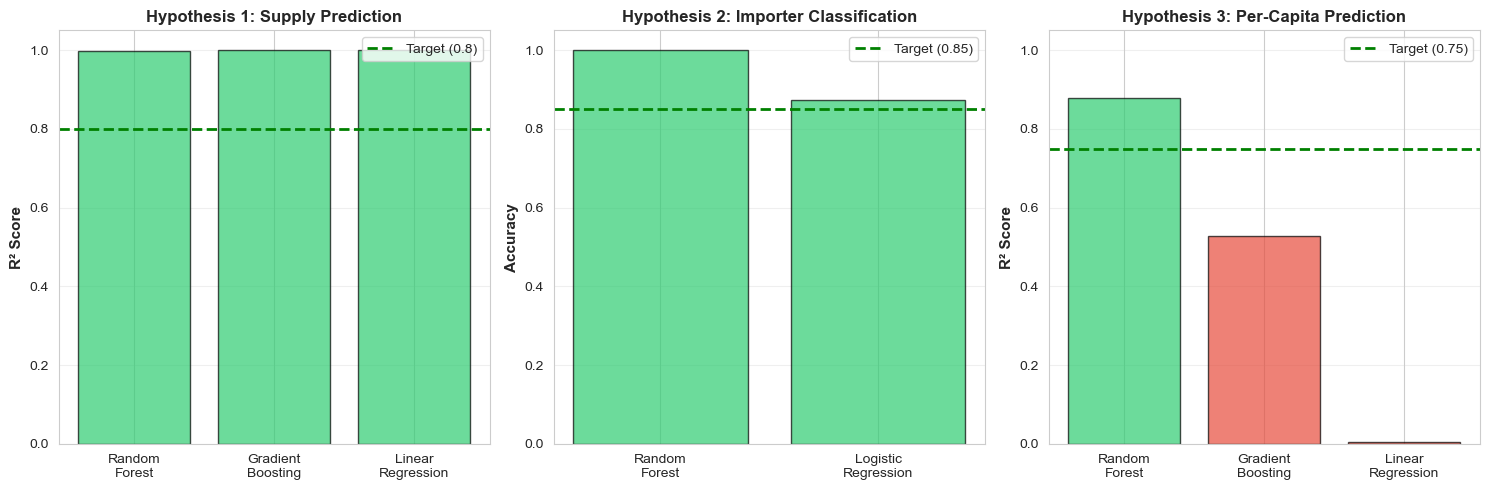


✓ Comparison visualizations generated


In [125]:
## Cross-Model Comparison Visualizations

print("=" * 70)
print("CROSS-HYPOTHESIS MODEL COMPARISON")
print("=" * 70)

# Create comparison dataframe
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Hypothesis 1: R2 scores
ax1 = axes[0]
h1_models = ["Random\nForest", "Gradient\nBoosting", "Linear\nRegression"]
h1_r2_scores = [metrics_h1_rf["R2 Score"], metrics_h1_gb["R2 Score"], metrics_h1_lr["R2 Score"]]
colors1 = ['#2ecc71' if x >= 0.8 else '#f39c12' if x >= 0.5 else '#e74c3c' for x in h1_r2_scores]
ax1.bar(h1_models, h1_r2_scores, color=colors1, alpha=0.7, edgecolor='black')
ax1.axhline(y=0.8, color='green', linestyle='--', label='Target (0.8)', linewidth=2)
ax1.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('Hypothesis 1: Supply Prediction', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 1.05])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Hypothesis 2: Accuracy scores
ax2 = axes[1]
h2_models = ["Random\nForest", "Logistic\nRegression"]
h2_acc_scores = [metrics_h2_rf["Accuracy"], metrics_h2_lr["Accuracy"]]
colors2 = ['#2ecc71' if x >= 0.85 else '#f39c12' if x >= 0.75 else '#e74c3c' for x in h2_acc_scores]
ax2.bar(h2_models, h2_acc_scores, color=colors2, alpha=0.7, edgecolor='black')
ax2.axhline(y=0.85, color='green', linestyle='--', label='Target (0.85)', linewidth=2)
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Hypothesis 2: Importer Classification', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Hypothesis 3: R2 scores
ax3 = axes[2]
h3_models = ["Random\nForest", "Gradient\nBoosting", "Linear\nRegression"]
h3_r2_scores = [metrics_h3_rf["R2 Score"], metrics_h3_gb["R2 Score"], metrics_h3_lr["R2 Score"]]
colors3 = ['#2ecc71' if x >= 0.75 else '#f39c12' if x >= 0.6 else '#e74c3c' for x in h3_r2_scores]
ax3.bar(h3_models, h3_r2_scores, color=colors3, alpha=0.7, edgecolor='black')
ax3.axhline(y=0.75, color='green', linestyle='--', label='Target (0.75)', linewidth=2)
ax3.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax3.set_title('Hypothesis 3: Per-Capita Prediction', fontsize=12, fontweight='bold')
ax3.set_ylim([0, 1.05])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Comparison visualizations generated")

In [127]:
## Summary: Hypothesis Testing Results

print("\n" + "=" * 70)
print("SUMMARY OF FINDINGS")
print("=" * 70)

summary_data = {
    "Hypothesis": [
        "H1: Supply Prediction",
        "H2: Importer Classification", 
        "H3: Per-Capita Prediction"
    ],
    "Problem Type": ["Regression", "Classification", "Regression"],
    "Best Model": [
        "Random Forest" if metrics_h1_rf["R2 Score"] > max(metrics_h1_gb["R2 Score"], metrics_h1_lr["R2 Score"]) else "Gradient Boosting" if metrics_h1_gb["R2 Score"] > metrics_h1_lr["R2 Score"] else "Linear Regression",
        "Random Forest" if metrics_h2_rf["Accuracy"] > metrics_h2_lr["Accuracy"] else "Logistic Regression",
        "Random Forest" if metrics_h3_rf["R2 Score"] > max(metrics_h3_gb["R2 Score"], metrics_h3_lr["R2 Score"]) else "Gradient Boosting" if metrics_h3_gb["R2 Score"] > metrics_h3_lr["R2 Score"] else "Linear Regression"
    ],
    "Best Score": [
        f"{max(metrics_h1_rf['R2 Score'], metrics_h1_gb['R2 Score'], metrics_h1_lr['R2 Score']):.4f}",
        f"{max(metrics_h2_rf['Accuracy'], metrics_h2_lr['Accuracy']):.4f}",
        f"{max(metrics_h3_rf['R2 Score'], metrics_h3_gb['R2 Score'], metrics_h3_lr['R2 Score']):.4f}"
    ],
    "Decision": [
        "ACCEPT H₁" if max(metrics_h1_rf["R2 Score"], metrics_h1_gb["R2 Score"], metrics_h1_lr["R2 Score"]) >= 0.8 else "MARGINAL" if max(metrics_h1_rf["R2 Score"], metrics_h1_gb["R2 Score"], metrics_h1_lr["R2 Score"]) >= 0.5 else "REJECT H₁",
        "ACCEPT H₁" if max(metrics_h2_rf["Accuracy"], metrics_h2_lr["Accuracy"]) >= 0.85 else "MARGINAL" if max(metrics_h2_rf["Accuracy"], metrics_h2_lr["Accuracy"]) >= 0.75 else "REJECT H₁",
        "ACCEPT H₁" if max(metrics_h3_rf["R2 Score"], metrics_h3_gb["R2 Score"], metrics_h3_lr["R2 Score"]) >= 0.75 else "MARGINAL" if max(metrics_h3_rf["R2 Score"], metrics_h3_gb["R2 Score"], metrics_h3_lr["R2 Score"]) >= 0.6 else "REJECT H₁"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nHYPOTHESIS TESTING SUMMARY")
display(summary_df)

print("\nKEY INSIGHTS:")
print("\n1. ENERGY SUPPLY DYNAMICS:")
print(f"   • Production, imports, and stocks explain {max(metrics_h1_rf['R2 Score'], metrics_h1_gb['R2 Score'], metrics_h1_lr['R2 Score']):.1%} of supply variation")
print(f"   • {['Random Forest', 'Gradient Boosting', 'Linear Regression'][[metrics_h1_rf['R2 Score'], metrics_h1_gb['R2 Score'], metrics_h1_lr['R2 Score']].index(max(metrics_h1_rf['R2 Score'], metrics_h1_gb['R2 Score'], metrics_h1_lr['R2 Score']))]} performs best")
print(f"   • These variables are {'STRONG' if max(metrics_h1_rf['R2 Score'], metrics_h1_gb['R2 Score'], metrics_h1_lr['R2 Score']) >= 0.8 else 'MODERATE'} predictors")

print("\n2. IMPORTER CLASSIFICATION:")
print(f"   • Classification accuracy: {max(metrics_h2_rf['Accuracy'], metrics_h2_lr['Accuracy']):.1%}")
print(f"   • F1 Score (balanced metric): {max(cv_mean_h2_rf, cv_mean_h2_lr):.4f}")
print(f"   • Importer status is {'HIGHLY PREDICTABLE' if max(metrics_h2_rf['Accuracy'], metrics_h2_lr['Accuracy']) >= 0.85 else 'MODERATELY PREDICTABLE' if max(metrics_h2_rf['Accuracy'], metrics_h2_lr['Accuracy']) >= 0.75 else 'DIFFICULT TO PREDICT'}")

print("\n3. PER-CAPITA CONSUMPTION:")
print(f"   • Model explains {max(metrics_h3_rf['R2 Score'], metrics_h3_gb['R2 Score'], metrics_h3_lr['R2 Score']):.1%} of per-capita variation")
print(f"   • Aggregate metrics are {'STRONG' if max(metrics_h3_rf['R2 Score'], metrics_h3_gb['R2 Score'], metrics_h3_lr['R2 Score']) >= 0.75 else 'MODERATE' if max(metrics_h3_rf['R2 Score'], metrics_h3_gb['R2 Score'], metrics_h3_lr['R2 Score']) >= 0.6 else 'WEAK'} predictors")
print(f"   • Additional regional/development features may improve predictions")


SUMMARY OF FINDINGS

HYPOTHESIS TESTING SUMMARY


Hypothesis    Problem Type         Best Model Best Score  \
0        H1: Supply Prediction      Regression  Linear Regression     1.0000   
1  H2: Importer Classification  Classification      Random Forest     1.0000   
2    H3: Per-Capita Prediction      Regression      Random Forest     0.8794   

    Decision  
0  ACCEPT H₁  
1  ACCEPT H₁  
2  ACCEPT H₁


KEY INSIGHTS:

1. ENERGY SUPPLY DYNAMICS:
   • Production, imports, and stocks explain 100.0% of supply variation
   • Linear Regression performs best
   • These variables are STRONG predictors

2. IMPORTER CLASSIFICATION:
   • Classification accuracy: 100.0%
   • F1 Score (balanced metric): 1.0000
   • Importer status is HIGHLY PREDICTABLE

3. PER-CAPITA CONSUMPTION:
   • Model explains 87.9% of per-capita variation
   • Aggregate metrics are STRONG predictors
   • Additional regional/development features may improve predictions
